In [5]:
import numpy as np
from numba import njit
from scipy import optimize
import datetime
import xarray as xr 
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
import warnings
import pickle
warnings.filterwarnings('ignore')

#sns.set(font='Franklin Gothic Book',
sns.set(rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'black',#dimgrey
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})

sns.set_context("notebook", rc={"font.size":16,"axes.titlesize":20,"axes.labelsize":18})

import os
    
plotdir = './plots/precip/'
if not os.path.exists(plotdir):
    os.makedirs(plotdir)   


def calculate_precipitation_hist(values,bins):
    '''Calculate the distribution of precipitation given a numpy array of whatever size and bins.'''
    values=values.reshape(-1)
    a=np.histogram(values, bins=bins)
    return a[0],values.shape[0]

def calculate_precipitation_distribution(values,bins):
    '''Calculate the distribution of precipitation given a numpy array of whatever size and bins.'''
    values=values.reshape(-1)
    a=np.histogram(values, bins=bins)
    return a[0]/values.shape[0],bins

    
def load_total_precip_obs(REGION,MON):
    file=f'/work/bm1235/u233156/observations/GPM_IMERG/GPM_IMERG_hourly_2020_{MON}_{REGION}.nc'
    ds = xr.open_dataset(file,engine='netcdf4')['precipitationCal'].load()
    return ds

def plot_Berthou_all(a,b,a_obs,b_obs,REGION2,resol,exp_list,color_list,array_linestyle,array_linewidth):
    
    plt.figure(figsize=(10,6))

    for (i,exp),color,linestyle,linewidth in zip(enumerate(exp_list),color_list,array_linestyle,array_linewidth):
        aa=np.array(a[i])/np.array(b[i])
        plt.plot((bins[0:-1]+bins[1:])/2,aa*(bins[0:-1]+bins[1:])/2,label=exp,color=color,linestyle=linestyle,linewidth=linewidth)
    plt.xscale('log')
    plt.xlabel('P [mm/hour]')
    plt.ylabel('f(P) * P')
    aa_obs=a_obs/b_obs
    plt.plot((bins[0:-1]+bins[1:])/2,aa_obs*(bins[0:-1]+bins[1:])/2,label='GPM IMERG',color='k')
    plt.title(f'{REGION2}, {resol}, 01/2020-08/2020')
    plt.xlim([0.01,200])
    plt.ylim([0.,.008])
    plt.legend()
    plt.tight_layout()
    plt.legend(frameon=False) 
 

In [6]:
# THIS STEP IS ONLY NECESSARY IF PICKLE IS NOT USED!!


array_yea= ["2020"]
array_mon= ["01","02","03","04","05","06","07","08"]#


exp_list      = ["4km_fesom","ifs_cycle2_4km_tp","9km_nemo","ifs_cycle2_9km_tp","9km_fesom","ifs_cycle2_3km_tp"]
expid_list= ["hzfy","hqys","hz9o","hr2n","hz9o","hr0n"]
# FESOM family is red, NEMO family blue
color_list    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
# give IFS resolution only, FESOM/NEMO don't change from 25/5km
name_list   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
# Cycle 3 is solid, Cycle 2/1 dashed
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
# main simulation is thicker to stand out
array_linewidth= [2,1,1,1,1,1]

a_all = {} 
b_all = {}
a = {}
b = {}
a_obs = {}
b_obs = {}


bins=np.array([0.002*np.exp(0.12*i) for i in range(200)])


REGION='tropics'
REGION2='tropics'
resol='0.1x0.1$^{\circ}$, hourly'




for (e,exp),expid in zip(enumerate(exp_list),expid_list): 
  a_all[e] = np.zeros(len(bins)-1)
  b_all[e] = 0
  for y,YEA in enumerate(array_yea):
     for m,MON in enumerate(array_mon):
            a[e,y,m] = []
            if  array_linestyle[e] == "solid": 
              file=f'/work/bm1235/u233156/IFS_cycle3/{exp}/{expid}_2D_precip_hourly_remap_0.1x0.1_{YEA}{MON}_{REGION}.nc'
              ds = xr.open_dataset(file,engine='netcdf4')['tp'].load()
              ds.values = ds.values
            else:
              file=f'/work/bm1235/u233156/IFS_cycle2/tp_mmperd_{expid}_alltimes_remap_0.1x0.1_tropics_{YEA}{MON}.nc'
              ds = xr.open_dataset(file,engine='netcdf4')['var228'].load()
              ds.values = ds.values /24 #from mm/d to mm/h
            a[e,y,m],b[e,y,m]=calculate_precipitation_hist(ds.values,bins)           
            b_all[e] = b_all[e] + b[e,y,m]
            a_all[e] = np.array(a_all[e])+np.array(a[e,y,m])
    


a_obs_all = np.zeros(len(bins)-1)
b_obs_all = 0

for y,YEA in enumerate(array_yea):
   for m,MON in enumerate(array_mon):   
        a_obs[y,m] = []
        pr=load_total_precip_obs(REGION,MON) 
        a_obs[y,m],b_obs[y,m]=calculate_precipitation_hist(pr.values,bins)
        b_obs_all = b_obs_all + b_obs[y,m]
        a_obs_all = a_obs_all + np.array(a_obs[y,m])
        
# WRITE PICKLE

# Open a file and use dump()
with open('../data/precipitation_distribution_Berthou_NextGEMS_Cycle3_Cycle2_4km_9km_ICON_GPM_tropics_202001to08.pickle', 'wb') as file:
      
    # A new file will be created
    pickle.dump([a_all,b_all,a_obs_all,b_obs_all], file)        

In [6]:
# CONTINUE HERE IF PICKLE IS USED

with open(f'../data/precipitation_distribution_Berthou_NextGEMS_Cycle3_Cycle2_4km_9km_ICON_GPM_tropics_202001to08.pickle', 'rb') as file:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    a_all,b_all,a_obs_all,b_obs_all = pickle.load(file)

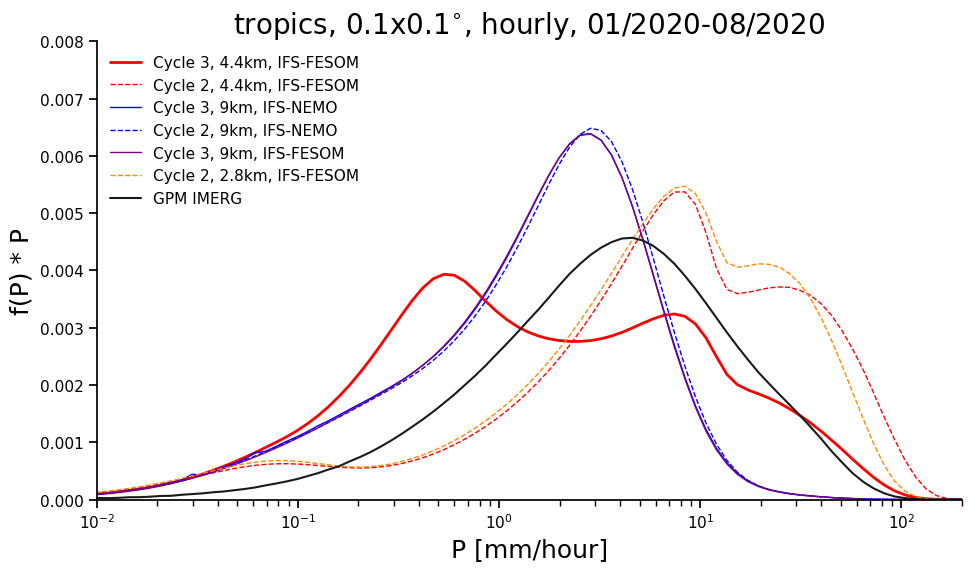

In [7]:
color_list    = ["#ff0000","#ff0000","#0000ff","#0000ff","purple","darkorange"]
name_list   = ["Cycle 3, 4.4km, IFS-FESOM","Cycle 2, 4.4km, IFS-FESOM","Cycle 3, 9km, IFS-NEMO","Cycle 2, 9km, IFS-NEMO","Cycle 3, 9km, IFS-FESOM","Cycle 2, 2.8km, IFS-FESOM"]
array_linestyle= ["solid","dashed","solid","dashed","solid","dashed"]
array_linewidth= [2,1,1,1,1,1]

bins=np.array([0.002*np.exp(0.12*i) for i in range(200)])

REGION='tropics'
REGION2='tropics'
resol='0.1x0.1$^{\circ}$, hourly'        
        
plot_Berthou_all(a_all,b_all,a_obs_all,b_obs_all,REGION2,resol,name_list,color_list,array_linestyle,array_linewidth)
plt.tight_layout()
plt.savefig(plotdir + f'precipitation_distribution_Berthou_NextGEMS_Cycle3_Cycle2_4km_9km_ICON_GPM_{REGION}_202001to08.png')  
plt.savefig(plotdir + f'precipitation_distribution_Berthou_NextGEMS_Cycle3_Cycle2_4km_9km_ICON_GPM_{REGION}_202001to08.pdf')         